In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.contrib.layers as layers
import seaborn as sns

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
from flows import NVPFlow, FlowSequence, ResFlow, BNFlow, phase, floatX, Normalizer

In [3]:
inp = tf.placeholder(floatX, [None, 2])

In [4]:
# flow = ResFlow(2, 'res_init', normalize=False)(inp)
flow = NVPFlow(2, name='nvp_init', normalize=False)(inp)

for i in range(0, 9):
#     flow = ResFlow(name='res_' + str(i), normalize=False)(flow)
    flow = NVPFlow(name='nvp_' + str(i), normalize=False)(flow)

In [5]:
flow[-1].output /= 2

In [6]:
flow[-1].logj.shape

TensorShape([Dimension(None)])

In [7]:
flows = flow

In [8]:
logj = flows.calc_logj()

In [9]:
logj

<tf.Tensor 'add_10:0' shape=(?,) dtype=float32>

In [10]:
mm = np.zeros(2, np.int)
for fl in flows:
    if hasattr(fl, 'mask'):
        mm += fl.mask
        print(fl.mask)

[ True False]
[False  True]
[ True False]
[False  True]
[ True False]
[False  True]
[ True False]
[False  True]
[ True False]
[False  True]


In [11]:
mm

array([5, 5])

In [12]:
with tf.name_scope('gain_scope'):
    z = flows[-1].output
    gain = tf.reduce_sum(-(z*z)/2, axis=-1) + logj
    gain = tf.reduce_mean(gain)

In [13]:
lr = tf.Variable(0.001, trainable=False, name='learning_rate')
train_op = tf.train.AdamOptimizer(lr).minimize(-gain)
train_op = [train_op] + flows.get_ops()

In [14]:
X, _ = make_moons(n_samples=4024, noise=0.13)

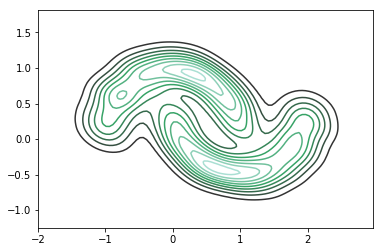

In [15]:
sns.kdeplot(X[:,0], X[:,1], kernel='tri')
plt.show()

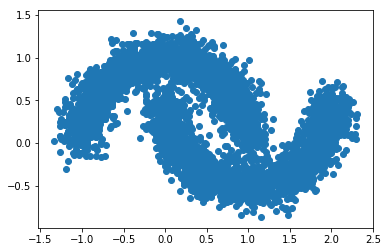

In [16]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [17]:
sess = tf.InteractiveSession()

In [18]:
tf.global_variables_initializer().run()

In [19]:
logj.eval({inp:X, phase: False}).mean()

0.00787701

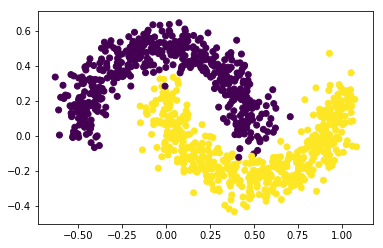

In [20]:
X, y = make_moons(n_samples=1024, noise=0.13)
ver = z.eval({inp:X, phase:False})

ax = plt.gca()
ax.set_aspect('equal')
plt.scatter(ver[:,0], ver[:,1], c=y)
plt.show()

In [21]:
# sess.run(lr.assign(0.0001))

In [22]:
!rm -R /tmp/tfdbg
writer = tf.summary.FileWriter('/tmp/tfdbg')

In [23]:
writer.add_graph(tf.get_default_graph())

In [24]:
all_sum = tf.summary.merge_all()

In [25]:
for _ in range(80):
    for _ in range(300):
        X, _ = make_moons(n_samples=256, noise=0.13)
        sess.run(train_op, {inp:X, phase:True})
    print(gain.eval({inp:X, phase: True}))
    #writer.add_summary(all_sum.eval({inp:X, phase:True}))

1.278559
1.2776146
1.4489009
1.5139332
1.6138953
1.5559
1.626117
1.6381047
1.6403807
1.7710755
1.6776986
1.72407
1.6467984
1.708415
1.738018
1.7441529
1.6759493
1.7265387
1.7203263
1.737444
1.7543095
1.7945534
1.7395318
1.7020707
1.7081208
1.6401174
1.7664624
1.8050976
1.7647963
1.7871658


KeyboardInterrupt: 

In [27]:
inverse = flows.apply(inp*2, inverse=True)

In [28]:
restored = inverse.eval({inp:np.random.normal(size=[1000,2]), phase: False})
#restored = inverse.eval({inp:ver})

In [29]:
restored = restored[np.logical_not(np.any(restored**2 > 30, axis=-1))]

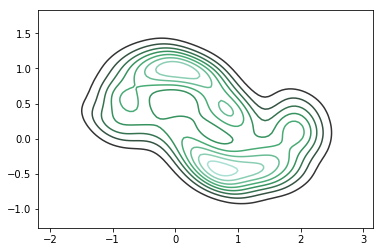

In [30]:
sns.kdeplot(restored[:,0], restored[:,1])
plt.show()

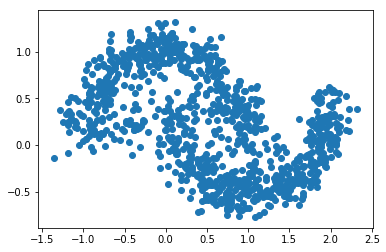

In [31]:
plt.scatter(restored[:,0], restored[:,1])
plt.show()